
#Sarcasm Detection on Airline Reviews - Data Preprocessing

This notebook demonstrates the steps for preprocessing a dataset for sarcasm detection in Airline Reviews using deep learning. The preprocessing steps include loading the dataset, cleaning the data, and preparing the data for model training.

#Dataset Overview
We are using a dataset of Airline Reviews which contains the following columns:

`Review`: The text of the YouTube comment.

`sarcasm`: The target label indicating whether the comment is sarcastic (1) or not (0).


Additional features related to airline information.

Let's load the dataset and take a look at its structure.

In [22]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
dataset_path = '/content/drive/My Drive/Airline_Reviews_Labeled.csv'
  # Update with your dataset path
data = pd.read_csv(dataset_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Taking subset of the dataset

In [23]:
# Randomly sample 8000 records
sampled_data = data.sample(n=8000, random_state=42)

##Splitting the dataset into training and testing data

In [24]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(sampled_data['Review'], sampled_data['sarcasm'], test_size=0.2, random_state=42)


In [25]:
# Convert to DataFrame for preprocessing
train_data = pd.DataFrame({'text': X_train, 'label': y_train})

#Data Visualization

In [26]:
# Describe the dataset
print(train_data.describe())

             label
count  6400.000000
mean      0.715625
std       0.451151
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


In [27]:
# Shape of the dataset
print(train_data.shape)

(6400, 2)


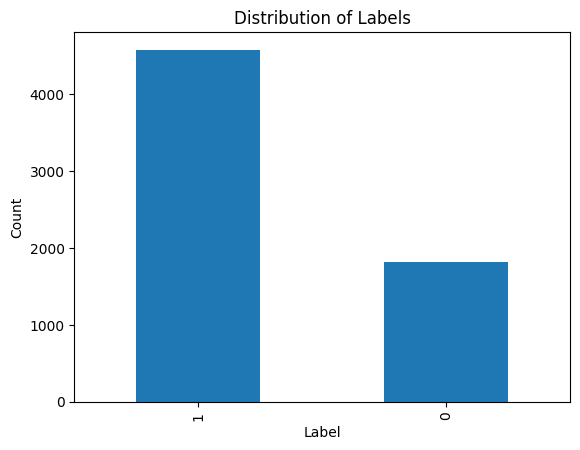

In [28]:
import matplotlib.pyplot as plt
# Distribution of labels
train_data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


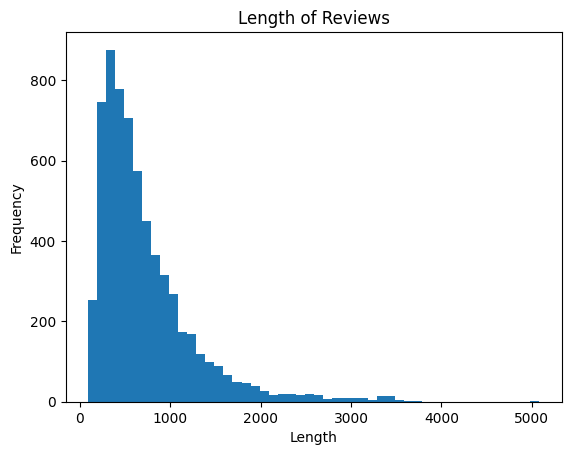

In [29]:
import matplotlib.pyplot as plt

# Length of reviews
train_data['review_length'] = train_data['text'].apply(len)
plt.hist(train_data['review_length'], bins=50)
plt.title('Length of Reviews')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()


In [30]:
# Check for missing values
print(train_data.isnull().sum())


text             0
label            0
review_length    0
dtype: int64


In [31]:
# Check for duplicates
print(train_data.duplicated().sum())

# Remove duplicates
train_data = train_data.drop_duplicates()


7


In [32]:
# List of columns to drop
columns_to_drop = [
    'Unnamed: 0','Airline Name','Overall_Rating','Review_Title','Review Date',
    'Verified','Aircraft','Type Of Traveller','Route', 'Seat Type', 'Date Flown',
    'Seat Comfort','Cabin Staff Service', 'Food & Beverages',
    'Ground Service', 'Inflight Entertainment',
    'Wifi & Connectivity', 'Value For Money','Recommended',
]

# Drop columns
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')


#Data Cleaning

In [33]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Text Cleaning
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-33-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


##Tokenization

In [34]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_data['tokenized_text'] = train_data['clean_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


Token indices sequence length is longer than the specified maximum sequence length for this model (717 > 512). Running this sequence through the model will result in indexing errors


## Removing Stopwords

In [35]:
stop_words = set(stopwords.words('english'))
# Remove stop words
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

##Label encoding

In [36]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])


##Text vectorization

In [37]:
from gensim.models import Word2Vec
import numpy as np
# Prepare data for Word2Vec
sentences = [text.split() for text in train_data['clean_text']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Get Word2Vec vectors for the training data
train_data['word2vec'] = train_data['clean_text'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))


##Handling imbalanced data

In [38]:
from imblearn.over_sampling import SMOTE

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_data['word2vec'].tolist(), train_data['encoded_label'])


#Traning and Testing Machine learning models

##1. Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Evaluate on training data
y_train_pred_rf = rf_model.predict(X_resampled)
print("--- Random Forest Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_rf))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate on testing data
y_test_pred_rf = rf_model.predict(X_test_vectors)
print("--- Random Forest Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Recall:", recall_score(y_test, y_test_pred_rf, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_rf, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_rf, average='macro'))


--- Random Forest Training Data ---
Accuracy: 1.0


<ipython-input-33-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- Random Forest Testing Data ---
Accuracy: 0.834375
Recall: 0.8214035087719298
Precision: 0.8000524109014675
F1 Score: 0.8088173958133715


##2. Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on training data
y_train_pred_svm = svm_model.predict(X_resampled)
print("--- SVM Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_svm))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate on testing data
y_test_pred_svm = svm_model.predict(X_test_vectors)
print("--- SVM Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("Recall:", recall_score(y_test, y_test_pred_svm, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_svm, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_svm, average='macro'))


--- SVM Training Data ---
Accuracy: 0.8531789381691064


<ipython-input-34-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- SVM Testing Data ---
Accuracy: 0.84375
Recall: 0.8511812865497076
Precision: 0.81256297895233
F1 Score: 0.8249777721770664


##3. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_resampled, y_resampled)

# Evaluate on training data
y_train_pred_lr = lr_model.predict(X_resampled)
print("--- Logistic Regression Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_lr))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate on testing data
y_test_pred_lr = lr_model.predict(X_test_vectors)
print("--- Logistic Regression Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("Recall:", recall_score(y_test, y_test_pred_lr, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_lr, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_lr, average='macro'))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression Training Data ---
Accuracy: 0.8468429102031899


<ipython-input-34-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- Logistic Regression Testing Data ---
Accuracy: 0.85
Recall: 0.8519766081871345
Precision: 0.8181673627568895
F1 Score: 0.8302300206376632


##4. GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes model
gnb_model = GaussianNB()
gnb_model.fit(X_resampled, y_resampled)

# Evaluate on training data
y_train_pred_gnb = gnb_model.predict(X_resampled)
print("--- Gaussian Naive Bayes Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_gnb))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate on testing data
y_test_pred_gnb = gnb_model.predict(X_test_vectors)
print("--- Gaussian Naive Bayes Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_gnb))
print("Recall:", recall_score(y_test, y_test_pred_gnb, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_gnb, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_gnb, average='macro'))


--- Gaussian Naive Bayes Training Data ---
Accuracy: 0.7959362027528949


<ipython-input-34-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- Gaussian Naive Bayes Testing Data ---
Accuracy: 0.79375
Recall: 0.8040701754385965
Precision: 0.7640566115924082
F1 Score: 0.7731643063725364


##5. Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_resampled, y_resampled)

# Evaluate on training data
y_train_pred_gb = gb_model.predict(X_resampled)
print("--- Gradient Boosting Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_gb))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate on testing data
y_test_pred_gb = gb_model.predict(X_test_vectors)
print("--- Gradient Boosting Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_gb))
print("Recall:", recall_score(y_test, y_test_pred_gb, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_gb, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_gb, average='macro'))


--- Gradient Boosting Training Data ---
Accuracy: 0.8762289709416649


<ipython-input-34-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- Gradient Boosting Testing Data ---
Accuracy: 0.829375
Recall: 0.836701754385965
Precision: 0.7979384003974168
F1 Score: 0.8096545412948983


#Conclusion

###Models with thier accuracies

*   Random Forest Classifier - 0.83
*   Support Vector Machine   - 0.84
*   LogisticRegression Model - 0.85
*   GaussianNB               - 0.79
*   Gradient Bossting        - 0.82














#Hyperparameter Tuning

###1. Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}


# Instantiate the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Instantiate the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on training data
best_rf_model = grid_search.best_estimator_
y_train_pred_rf = best_rf_model.predict(X_resampled)
print("--- Random Forest Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_rf))
print("Recall:", recall_score(y_resampled, y_train_pred_rf, average='macro'))
print("Precision:", precision_score(y_resampled, y_train_pred_rf, average='macro'))
print("F1 Score:", f1_score(y_resampled, y_train_pred_rf, average='macro'))

# Preprocess the testing data (assuming X_test and y_test are defined)
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate the best model on testing data
y_test_pred_rf = best_rf_model.predict(X_test_vectors)
print("--- Random Forest Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Recall:", recall_score(y_test, y_test_pred_rf, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_rf, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_rf, average='macro'))


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
--- Random Forest Training Data ---
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1 Score: 1.0


<ipython-input-33-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- Random Forest Testing Data ---
Accuracy: 0.834375
Recall: 0.8214035087719298
Precision: 0.8000524109014675
F1 Score: 0.8088173958133715


###2. Support Vector Machine

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4, 5]  # Only relevant for 'poly' kernel
}

# Instantiate the SVM classifier
svm_model = SVC(random_state=42)

# Instantiate the grid search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on training data
best_svm_model = grid_search.best_estimator_
y_train_pred_svm = best_svm_model.predict(X_resampled)
print("--- SVM Training Data ---")
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_svm))
print("Recall:", recall_score(y_resampled, y_train_pred_svm, average='macro'))
print("Precision:", precision_score(y_resampled, y_train_pred_svm, average='macro'))
print("F1 Score:", f1_score(y_resampled, y_train_pred_svm, average='macro'))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate the best model on testing data
y_test_pred_svm = best_svm_model.predict(X_test_vectors)
print("--- SVM Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("Recall:", recall_score(y_test, y_test_pred_svm, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_svm, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_svm, average='macro'))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters found:  {'C': 100, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
--- SVM Training Data ---
Accuracy: 0.883111208214988
Recall: 0.8831112082149879
Precision: 0.8856039384044159
F1 Score: 0.8829219960169397


<ipython-input-33-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- SVM Testing Data ---
Accuracy: 0.8525
Recall: 0.855578947368421
Precision: 0.8209459174142244
F1 Score: 0.8332202623247398


###3. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_lr_model = grid_search.best_estimator_

# Evaluate the best model on the training data
y_train_pred_lr = best_lr_model.predict(X_resampled)
print("--- Best Logistic Regression Model on Training Data ---")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_resampled, y_train_pred_lr))
print("Recall:", recall_score(y_resampled, y_train_pred_lr, average='macro'))
print("Precision:", precision_score(y_resampled, y_train_pred_lr, average='macro'))
print("F1 Score:", f1_score(y_resampled, y_train_pred_lr, average='macro'))

# Preprocess the testing data
X_test_clean = X_test.apply(clean_text)
X_test_tokenized = X_test_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X_test_vectors = X_test_tokenized.apply(lambda x: np.mean([word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv], axis=0))

# Ensure all vectors are the same length
X_test_vectors = np.array(X_test_vectors.tolist())

# Evaluate the best model on the testing data
y_test_pred_lr = best_lr_model.predict(X_test_vectors)
print("--- Best Logistic Regression Model on Testing Data ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("Recall:", recall_score(y_test, y_test_pred_lr, average='macro'))
print("Precision:", precision_score(y_test, y_test_pred_lr, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred_lr, average='macro'))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

--- Best Logistic Regression Model on Training Data ---
Best Parameters: {'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'}
Accuracy: 0.8731701988201879
Recall: 0.8731701988201879
Precision: 0.8734226240290792
F1 Score: 0.8731487616814941


<ipython-input-34-b8df1234f44a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


--- Best Logistic Regression Model on Testing Data ---
Accuracy: 0.87
Recall: 0.8661988304093566
Precision: 0.8397405515016727
F1 Score: 0.8504885179854047


###4. GaussianNB

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
import numpy as np

# Assuming X_resampled and y_resampled are your training data
# Assuming X_test_vectors and y_test are your testing data

# Define the GNB model
gnb_model = GaussianNB()

# Parameters to tune
parameters = {
    'priors': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]
}

# Choose a scoring method
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}

# Perform grid search cross-validation
clf = GridSearchCV(gnb_model, parameters, scoring=scoring, refit='accuracy', cv=5)
clf.fit(X_resampled, y_resampled)

# Print the best parameters and results
print("Best parameters found:")
print(clf.best_params_)
print()

print("Grid search results:")
means = clf.cv_results_['mean_test_accuracy']
stds = clf.cv_results_['std_test_accuracy']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("Accuracy: %0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    print("Recall:", clf.cv_results_['mean_test_recall'][np.argmax(means)])
    print("Precision:", clf.cv_results_['mean_test_precision'][np.argmax(means)])
    print("F1 Score:", clf.cv_results_['mean_test_f1_score'][np.argmax(means)])


Best parameters found:
{'priors': [0.9, 0.1]}

Grid search results:
Accuracy: 0.795 (+/-0.015) for {'priors': None}
Recall: 0.7964813754265396
Precision: 0.7994210886118663
F1 Score: 0.7959813091457631
Accuracy: 0.793 (+/-0.014) for {'priors': [0.1, 0.9]}
Recall: 0.7964813754265396
Precision: 0.7994210886118663
F1 Score: 0.7959813091457631
Accuracy: 0.793 (+/-0.014) for {'priors': [0.3, 0.7]}
Recall: 0.7964813754265396
Precision: 0.7994210886118663
F1 Score: 0.7959813091457631
Accuracy: 0.795 (+/-0.015) for {'priors': [0.5, 0.5]}
Recall: 0.7964813754265396
Precision: 0.7994210886118663
F1 Score: 0.7959813091457631
Accuracy: 0.796 (+/-0.013) for {'priors': [0.7, 0.3]}
Recall: 0.7964813754265396
Precision: 0.7994210886118663
F1 Score: 0.7959813091457631
Accuracy: 0.796 (+/-0.014) for {'priors': [0.9, 0.1]}
Recall: 0.7964813754265396
Precision: 0.7994210886118663
F1 Score: 0.7959813091457631


#Conclusion After hyperparameter tuning

###Models with thier accuracies

*   Random Forest Classifier - 0.83
*   Support Vector Machine   - 0.85
*   LogisticRegression Model - 0.87
*   GaussianNB               - 0.79
*   Gradient Bossting        - 0.82












